# Reto 4

## Andrea Castiella Aguirrezabala y Miguel Eduardo Ortiz Huamani

## Imports

In [1]:
import numpy as np
import OurUtils as our
import cv2
from PIL import Image

# Visualizacion
import matplotlib.pyplot as plt

# Carga de datos
import pandas as pd
import os

# Tensorflow
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization, ReLU
from tensorflow.keras import Model
from tensorflow.keras import layers
import keras

# tensorboard
from tensorboard import notebook

## Load data

In [2]:
class_names = ["aula", "cocina", "dormitorio", "oficina"]
data_path = "dataset"
train_im_names = [(os.listdir(os.path.join(data_path, label))) for label in class_names]
[train_im_names[i].sort(key= lambda x: (int(x[-3:]))) for i in range(len(train_im_names))]
train_im_names = np.hstack(np.array(train_im_names))
train_im_labels = np.array([class_names.index(name[:-3]) for name in train_im_names])
print(train_im_names, train_im_names.shape)
print(train_im_labels, train_im_labels.shape)

['aula001' 'aula002' 'aula003' ... 'oficina398' 'oficina399' 'oficina400'] (1600,)
[0 0 0 ... 3 3 3] (1600,)


In [3]:
test_size = .2
random_state = 123
X_train, Y_train, X_test, Y_test = our.single_stratified_split(train_im_names, train_im_labels, test_size=test_size, random_state=random_state)
print("Training set size: ", X_train.shape[0])
print("Validation set size: ", X_test.shape[0])
print("Example val")
print(X_test[0:5])
print(Y_test[0:5])
# print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
# print(np.where(Y_train==0)[0].shape)
# print(np.where(Y_train==1)[0].shape)
# print(np.where(Y_train==2)[0].shape)
# print(np.where(Y_train==3)[0].shape)
# print(">>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>")
# print(np.where(Y_test==0)[0].shape)
# print(np.where(Y_test==1)[0].shape)
# print(np.where(Y_test==2)[0].shape)
# print(np.where(Y_test==3)[0].shape)

Training set size:  1280
Validation set size:  320
Example val
['oficina139' 'aula112' 'aula272' 'dormitorio354' 'dormitorio228']
[3 0 0 2 2]


In [4]:
X_train = [np.array(Image.open(os.path.join(data_path, name[:-3], name))) for name in X_train]
X_test = [np.array(Image.open(os.path.join(data_path, name[:-3], name))) for name in X_test]


## Image shape differences
- define input size of the model

In [5]:
# from PIL import Image
# rgba_image = Image.fromarray(X_train[390])
# rgb_image = rgba_image.convert('RGB')
# rgb_image.show()
# print(rgb_image.shape)
X_train[390] = X_train[390][:,:,:3]
X_test[122] = X_test[122][:,:,:3]
for i in range(len(X_test)):
    h,w,c = X_test[i].shape 
    if c != 3:
        print(c)


h = []
w = []
for i in range(len(X_train)):
    im_shape = X_train[i].shape
    h.append(im_shape[0])
    w.append(im_shape[1])

h = np.array(h)
w = np.array(w)
print("h: ", np.unique(h), np.mean(h))
print("w: ", np.unique(w), np.mean(w))
# h: 148 | w: 154

h:  [ 72  92  98 103 104 107 108 109 110 120 126 129 131 132 133 134 135 136
 137 139 140 141 142 144 147 148 149 150] 148.90625
w:  [ 72  92 120 150 180 239 240] 154.55078125


## Visualize data

(150, 150, 3)


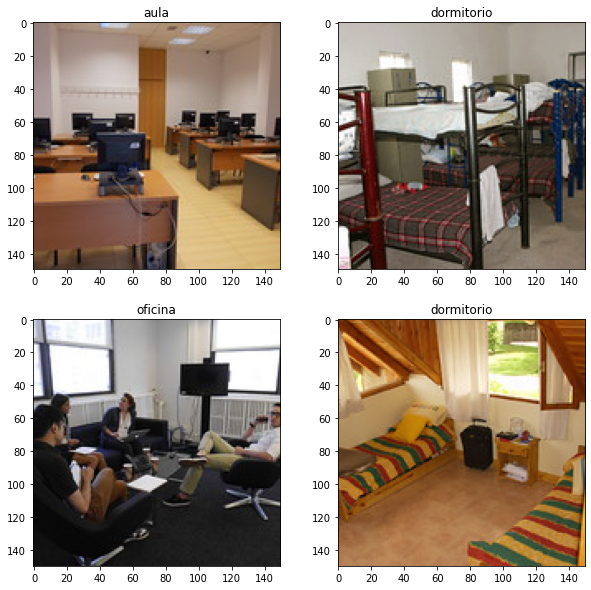

In [6]:
print(X_train[390].shape)
plt.figure(figsize=(10,10))

n_img = np.random.randint(0, len(X_train))
img_in = X_train[n_img]
img_label = Y_train[n_img]
ax1 = plt.subplot(2,2,1)
ax1.title.set_text(class_names[img_label])
plt.imshow(img_in)

n_img = np.random.randint(0, len(X_train))
img_in = X_train[n_img]
img_label = Y_train[n_img]
ax2 = plt.subplot(2, 2, 2)
ax2.title.set_text(class_names[img_label])
plt.imshow(img_in)

n_img = np.random.randint(0, len(X_train))
img_in = X_train[n_img]
img_label = Y_train[n_img]
ax3 = plt.subplot(2, 2, 3)
ax3.title.set_text(class_names[img_label])
plt.imshow(img_in)

n_img = np.random.randint(0, len(X_train))
img_in = X_train[n_img]
img_label = Y_train[n_img]
ax4 = plt.subplot(2, 2, 4)
ax4.title.set_text(class_names[img_label])
plt.imshow(img_in)

plt.show()

## Process data

In [7]:
print(type(X_train), len(X_train), X_train[0].shape)
mm = X_train[:2]
print(type(mm), len(mm), mm[0].shape, mm[1].shape)
kk = np.array(mm)
print(kk.shape)

<class 'list'> 1280 (150, 150, 3)
<class 'list'> 2 (150, 150, 3) (150, 150, 3)
(2, 150, 150, 3)


In [8]:
# normalize and resize
resize_rescales = tf.keras.Sequential(
    [layers.experimental.preprocessing.Resizing(148,154),
    layers.experimental.preprocessing.Rescaling(1./255)]
)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal")#,
  #layers.RandomRotation(0.2),
])

# resize
# X_train = resize_rescales(X_train)
# X_test = resize_rescales(X_test)
for i in range(len(X_train)):
    X_train[i] = data_augmentation(X_train[i])
    X_train[i] = resize_rescales(X_train[i])
    # print(">>> ", X_train[i].shape)

for i in range(len(X_test)):
    X_test[i] = data_augmentation(X_test[i])
    X_test[i] = resize_rescales(X_test[i])
    # print(">>> ", X_test[i].shape)
# data augmentation (?)

# dimensions [batch, channels, h, w]
# print(X_test[122].shape)
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, Y_train)).shuffle(64).batch(16)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).shuffle(16).batch(16)

# for images, labels in test_ds:
#     print(images.shape)

## Model

In [9]:
# modelos
# conv + conv + conv + fc + fc(4)
# conv + conv + conv + fc + fc(4)

class FeatureExtractor(keras.layers.Layer):
  
  def __init__(self, filters):
    self.conv1 = Conv2D(filters=filters[0],
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')

    self.conv2 = Conv2D(filters=filters[1],
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')

    self.conv3 = Conv2D(filters=filters[2],
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')

  def call(self, input):
    x = self.conv1(input)
    x = self.conv2(x)
    x = self.conv3(x)
    return x

class OursRedReto4(Model):
  def __init__(self, feat_filters):
    super(OursRedReto4, self).__init__()
    self.conv1 = Conv2D(filters=feat_filters[0],
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')

    self.conv2 = Conv2D(filters=feat_filters[1],
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')

    self.conv3 = Conv2D(filters=feat_filters[2],
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')


    self.batch1 = BatchNormalization(epsilon=1e-05, momentum=0.1)
    self.batch2 = BatchNormalization(epsilon=1e-05, momentum=0.1)
    self.batch3 = BatchNormalization(epsilon=1e-05, momentum=0.1)

    # self.feat_dimensions = () # algo 
    self.flatten = keras.layers.Flatten()
    #self.maxpool=tf.nn.max_pool(2,2)
    self.max_pool_2d = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),
        strides=(1, 1), padding='valid')

    self.fc1 = Dense(128,activation="relu")
    self.fc2 = Dense(4,activation="softmax")

  def call(self,x):
    x = self.conv1(x)
    #x = self.batch1(x)
    #x = self.max_pool_2d(x)
    x = self.conv2(x)
    #x = self.batch2(x)
    #x = self.max_pool_2d(x)
    x = self.conv3(x)
    #x = self.batch3(x)
    #x = self.max_pool_2d(x)
    # x = tf.reshape(x, [-1, self.feat_dimensions])
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x




class OurResnet(Model):
  def __init__(self, feat_filters):
    super(OurResnet, self).__init__()
    self.conv0 = Conv2D(filters=feat_filters[0],
               kernel_size=3,
               activation='relu',
               strides=1,
               padding='same')

    self.conv1 = Conv2D(filters=feat_filters[1],
               kernel_size=3,
               activation='relu',
               strides=1,
               padding='same')

    self.conv2 = Conv2D(filters=feat_filters[2],
               kernel_size=3,
               activation='relu',
               strides=1,
               padding='same')

    self.conv3 = Conv2D(filters=feat_filters[3],
               kernel_size=3,
               activation='relu',
               strides=1,
               padding='same')

    self.conv4 = Conv2D(filters=feat_filters[4],
               kernel_size=3,
               activation='relu',
               strides=1,
               padding='same')
    
    self.conv5 = Conv2D(filters=feat_filters[4],
               kernel_size=3,
               activation='relu',
               strides=1,
               padding='same')

    self.batch1 = BatchNormalization(epsilon=1e-05, momentum=0.1)
    self.batch2 = BatchNormalization(epsilon=1e-05, momentum=0.1)

    self.Relu = ReLU()

    self.flatten = keras.layers.Flatten()

    self.fc1 = Dense(128,activation="relu")
    self.fc2 = Dense(4,activation="softmax")

  def call(self,x):

    x = self.conv0(x)
    
    xin = tf.identity(x)
    x = self.conv1(x)
    x = self.batch1(x)
    x = self.Relu(x)
    x = self.conv2(x)
    x = self.batch1(x)
    x = xin + x
    x = self.Relu(x)

    #x = self.conv3(x)
    xin = tf.identity(x)
    x = self.conv4(x)
    x = self.batch2(x)
    x = self.Relu(x)
    x = self.conv5(x)
    x = self.batch2(x)
    x = xin + x
    x = self.Relu(x)

    x = self.flatten(x)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

## Trainer
- optimizer
- loss function
- metrics

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
# tf.config.experimental.set_memory_growth(gpus[0], True)
# model = OursRedReto4([8,16,32])
model = OurResnet([64,64,64, 64, 64, 64])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
# loss_object = tf.keras.losses.CategoricalCrossentropy()
# metrics = tf.keras.metrics.CategoricalAccuracy()

#Escoge un optimizador y una funcion de perdida para el entrenamiento de tu modelo:
loss_object = tf.keras.losses.CategoricalCrossentropy()

# optimizer = tf.keras.optimizers.RMSprop()

#Escoge metricas para medir la perdida y exactitud del modelo. 
#Estas metricas acumulan los valores cada epoch y despues imprimen el resultado total.

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

#%load_ext tensorboard 
import datetime
stamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/muva%s' % stamp
writer = tf.summary.create_file_writer(logdir)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Trainer
- fit

In [11]:
EPOCHS = 7
depth = 4

#with tf.device('/GPU:0'):

for epoch in range(EPOCHS):

    for images, labels in train_ds:
        #print(images.shape, labels.shape, labels)
        labels = tf.one_hot(labels, depth)
        #print(labels.shape, labels)
        with tf.GradientTape() as tape:
            predictions = model(images)
            loss = loss_object(labels, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        train_loss(loss)
        acc = train_accuracy(labels, predictions)

    for test_images, test_labels in test_ds:
        predictions = model(images)
        t_loss = loss_object(labels, predictions)

        test_loss(t_loss)
        test_accuracy(labels, predictions)

    with writer.as_default():
        tf.summary.scalar("acc_train",train_accuracy.result()*100.,step=epoch)
        tf.summary.scalar("loss_train",train_loss.result()*100.,step=epoch)
        tf.summary.scalar("acc_test",test_accuracy.result()*100.,step=epoch)
        tf.summary.scalar("loss_test",test_loss.result()*100.,step=epoch)
        writer.flush()

    template = 'Epoch {}, Perdida: {}, Exactitud: {}, Perdida de prueba: {}, Exactitud de prueba: {}'
    print(template.format(epoch+1,
                            train_loss.result(),
                            train_accuracy.result()*100.,
                            test_loss.result(),
                            test_accuracy.result()*100.))
    
    # Reinicia las metricas para el siguiente epoch.
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

Epoch 1, Perdida: 3.349034547805786, Exactitud: 34.375, Perdida de prueba: 1.2052245140075684, Exactitud de prueba: 37.5
Epoch 2, Perdida: 0.952958881855011, Exactitud: 61.25, Perdida de prueba: 0.8675705790519714, Exactitud de prueba: 56.25
Epoch 3, Perdida: 0.6117542386054993, Exactitud: 76.484375, Perdida de prueba: 1.068098783493042, Exactitud de prueba: 56.25
Epoch 4, Perdida: 0.3590053915977478, Exactitud: 88.203125, Perdida de prueba: 0.1073986291885376, Exactitud de prueba: 100.0
Epoch 5, Perdida: 0.20486168563365936, Exactitud: 93.28125, Perdida de prueba: 0.2025415599346161, Exactitud de prueba: 81.25
Epoch 6, Perdida: 0.08313919603824615, Exactitud: 98.125, Perdida de prueba: 0.021694626659154892, Exactitud de prueba: 100.0
Epoch 7, Perdida: 0.020192697644233704, Exactitud: 99.921875, Perdida de prueba: 0.014672042801976204, Exactitud de prueba: 100.0


## Quantitative results
- accuracy

## Qualitative Results

In [12]:
class_names = ["test"]
data_path = "dataset"
chall_im_names = [(os.listdir(os.path.join(data_path, label))) for label in class_names]
chall_im_names = np.hstack(np.array(chall_im_names))

# n_img = np.random.randint(0, len(X_chall))
# img_in = X_chall[n_img]
# img_label = Y_chall[n_img]
# ax1 = plt.subplot(2,2,1)
# ax1.title.set_text(class_names[img_label])
# plt.imshow(img_in)

# n_img = np.random.randint(0, len(X_chall))
# img_in = X_chall[n_img]
# img_label = Y_chall[n_img]
# ax2 = plt.subplot(2, 2, 2)
# ax2.title.set_text(class_names[img_label])
# plt.imshow(img_in)

# n_img = np.random.randint(0, len(X_chall))
# img_in = X_chall[n_img]
# img_label = Y_chall[n_img]
# ax3 = plt.subplot(2, 2, 3)
# ax3.title.set_text(class_names[img_label])
# plt.imshow(img_in)

# n_img = np.random.randint(0, len(X_chall))
# img_in = X_chall[n_img]
# img_label = Y_chall[n_img]
# ax4 = plt.subplot(2, 2, 4)
# ax4.title.set_text(class_names[img_label])
# plt.imshow(img_in)

# plt.show()

# ##
# # normalize and resize
# resize_rescales = tf.keras.Sequential(
#     [layers.experimental.preprocessing.Resizing(148,154),
#     layers.experimental.preprocessing.Rescaling(1./255)]
# )

# # resize
# # X_chall = resize_rescales(X_chall)
# # X_test = resize_rescales(X_test)
# for i in range(len(X_chall)):
#     X_chall[i] = resize_rescales(X_chall[i])
#     # print(">>> ", X_chall[i].shape)

# for i in range(len(X_test)):
#     X_test[i] = resize_rescales(X_test[i])
#     print(">>> ", X_test[i].shape)
# # data augmentation (?)

# # dimensions [batch, channels, h, w]
# print(X_test[122].shape)
# chall_ds = tf.data.Dataset.from_tensor_slices(
#     (X_chall, Y_chall)).shuffle(64).batch(16)

# test_ds = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).shuffle(16).batch(16)

# # for images, labels in test_ds:
# #     print(images.shape)

# ##
# for test_images, test_labels in test_ds:
#         predictions = model(images)
#         t_loss = loss_object(labels, predictions)

#         test_loss(t_loss)
#         test_accuracy(labels, predictions)


In [13]:
X_chall = [np.array(Image.open(os.path.join(data_path, "test", name))) for name in chall_im_names]
print(len(X_chall))

400


In [14]:
for i in range(len(X_chall)):
    h,w,c = X_chall[i].shape 
    if c != 3:
        print(c)

In [15]:
for i in range(len(X_chall)):
    X_chall[i] = resize_rescales(X_chall[i])

In [16]:
chall_ds = tf.data.Dataset.from_tensor_slices((X_chall, chall_im_names)).batch(1)
model_chall = model

In [17]:
preds = []
for images, names in chall_ds:
    predictions = model_chall(images)
    preds.append([predictions.numpy(), names.numpy()[0].decode("utf-8")])

In [18]:
# n_img = np.random.randint(0, len(X_chall))
# img_in = X_chall[n_img]
# img_label = Y_chall[n_img]
# ax1 = plt.subplot(2,2,1)
# ax1.title.set_text(class_names[img_label])
# plt.imshow(img_in)

# n_img = np.random.randint(0, len(X_chall))
# img_in = X_chall[n_img]
# img_label = Y_chall[n_img]
# ax2 = plt.subplot(2, 2, 2)
# ax2.title.set_text(class_names[img_label])
# plt.imshow(img_in)

# n_img = np.random.randint(0, len(X_chall))
# img_in = X_chall[n_img]
# img_label = Y_chall[n_img]
# ax3 = plt.subplot(2, 2, 3)
# ax3.title.set_text(class_names[img_label])
# plt.imshow(img_in)

# n_img = np.random.randint(0, len(X_chall))
# img_in = X_chall[n_img]
# img_label = Y_chall[n_img]
# ax4 = plt.subplot(2, 2, 4)
# ax4.title.set_text(class_names[img_label])
# plt.imshow(img_in)

# plt.show()

[0.00102262 0.56720775 0.39036083 0.04140874]
1
[2.5601502e-04 6.8393224e-01 3.0987716e-01 5.9345854e-03]
1
[2.3103863e-02 9.7602171e-01 6.9401969e-05 8.0496608e-04]
1
[7.9840545e-05 2.0207157e-03 9.5827228e-01 3.9627206e-02]
2
[9.9961567e-01 4.5402223e-05 9.2311886e-05 2.4660584e-04]
0
[9.6588069e-01 1.6240074e-03 3.1906776e-02 5.8860687e-04]
0
[9.3618379e-05 6.5197520e-02 9.3444812e-01 2.6073522e-04]
2
[5.3442722e-07 3.0668435e-04 9.9969077e-01 2.0353641e-06]
2


<Figure size 3600x3600 with 0 Axes>

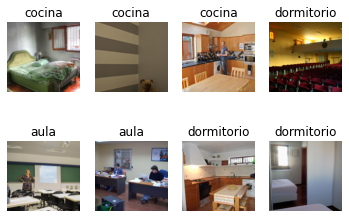

In [21]:
# Challenge images representation
from numpy.random import default_rng
numb_img = 8
rng = default_rng()
numbers = rng.choice(len(preds), size=numb_img, replace=False)

class_names = ["aula", "cocina", "dormitorio", "oficina"]

# chall_input = pd.read_csv('./reto1_X.csv', header=None)
# chall_input = chall_input / 255.0
# chall_input = chall_input.values.reshape([chall_input.shape[0],28,28])

# chall_results = pd.read_csv('./Reto1_Ypred.csv', header=None)
# chall_results = chall_results.values

# img_labels = np.zeros((numb_img,))
# for i in range(numb_img):
#     images[i] = chall_input[numbers[i],:,:]
#     pred = 7 if chall_results[numbers[i]] == 1 else 3
#     img_labels[i] = pred


plt.figure(figsize=(50,50))
f, axarr = plt.subplots(2,4)
x, y = 0, 0
for i in range(len(numbers)):

    acc = preds[numbers[i]][0][0]
    print(acc)
    best_label = np.argmax(acc)
    print(best_label)
    acc = acc[best_label]
    label = class_names[best_label]
    axarr[x,y].imshow(X_chall[numbers[i]])
    axarr[x,y].axis('off')
    axarr[x,y].title.set_text(label) # + " %.2f %"%acc
    y = y + 1
    if y == axarr.shape[1]:
        y = 0
        x = x + 1
        
# plt.imshow(images[0])
plt.show()